In [7]:
%matplotlib inline
import os
import collections
import torch
import torchvision
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt

from torch.utils import data

def recursive_glob(rootdir='.', suffix=''):
    """Performs recursive glob with given suffix and rootdir 
        :param rootdir is the root directory
        :param suffix is the suffix to be searched
    """
    return [os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames if filename.endswith(suffix)]


In [8]:
class SUNRGBDLoader(data.Dataset):
    def __init__(self, root, split="training", is_transform=False, img_size=(480, 640), img_norm=True):
        self.root = root
        self.is_transform = is_transform
        self.n_classes = 38
        self.img_norm = img_norm
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.color_files = collections.defaultdict(list)
        self.depth_files = collections.defaultdict(list)
        self.semantic_files = collections.defaultdict(list)
        self.cmap = self.color_map(normalized=False)

        split_map = {"training": 'train', "val": 'test',}
        self.split = split_map[split]

        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + '/color/', suffix='jpg'))
            self.color_files[split] = file_list
        
        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + '/depth/', suffix='png'))
            self.depth_files[split] = file_list    
        
        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + '/seg/', suffix='png'))
            self.semantic_files[split] = file_list


    def __len__(self):
        return len(self.color_files[self.split])


    def __getitem__(self, index):
        color_path = self.color_files[self.split][index].rstrip()
        depth_path = self.depth_files[self.split][index].rstrip()
        semantic_path = self.semantic_files[self.split][index].rstrip()

        color_img = m.imread(color_path)    
        color_img = np.array(color_img, dtype=np.uint8)

        depth_img = m.imread(depth_path)    
        depth_img = np.array(depth_img, dtype=np.uint8)
        
        semantic_img = m.imread(semantic_path)
        semantic_img = np.array(semantic_img, dtype=np.uint8)
        
        if self.is_transform:
            color_img, semantic_img = self.transform(color_img, semantic_img)
        
        return color_img, depth_img, semantic_img


    def transform(self, img, lbl):
        img = m.imresize(img, (self.img_size[0], self.img_size[1])) # uint8 with RGB mode
        img = img[:, :, ::-1] # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), 'nearest', mode='F')
        lbl = lbl.astype(int)
        assert(np.all(classes == np.unique(lbl)))

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl


    def color_map(self, N=256, normalized=False):
        """
        Return Color Map in PASCAL VOC format
        """

        def bitget(byteval, idx):
            return ((byteval & (1 << idx)) != 0)

        dtype = 'float32' if normalized else 'uint8'
        cmap = np.zeros((N, 3), dtype=dtype)
        for i in range(N):
            r = g = b = 0
            c = i
            for j in range(8):
                r = r | (bitget(c, 0) << 7-j)
                g = g | (bitget(c, 1) << 7-j)
                b = b | (bitget(c, 2) << 7-j)
                c = c >> 3

            cmap[i] = np.array([r, g, b])

        cmap = cmap/255.0 if normalized else cmap
        return cmap


    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.cmap[l,0]
            g[temp == l] = self.cmap[l,1]
            b[temp == l] = self.cmap[l,2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

In [9]:
import torchvision
import matplotlib.pyplot as plt

local_path = '/home/dongwonshin/Desktop/Datasets/SUN_RGBD(organized)/xtion'
dst = SUNRGBDLoader(local_path, is_transform=True)
bs = 2
trainloader = data.DataLoader(dst, batch_size=bs, num_workers=8)

TypeError: Invalid dimensions for image data

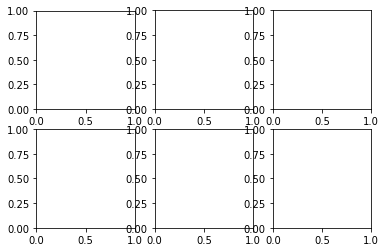

In [10]:
for i, data in enumerate(trainloader):
    color_img, depth_img, semantic_img = data
    color_img = color_img.numpy()
    depth_img = depth_img.numpy()
    semantic_img = semantic_img.numpy()
    f, axarr = plt.subplots(bs,3)
    
    for j in range(bs):      
        axarr[j][0].imshow(color_img[j])
        axarr[j][1].imshow(depth_img[j])
        axarr[j][2].imshow(semantic_img[j])
    plt.show()
#     break;

In [50]:
import sys, os
import torch
import visdom
import argparse
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm

from ptsemseg.models import get_model
from ptsemseg.loader import get_loader, get_data_path
from ptsemseg.metrics import runningScore
from ptsemseg.loss import *
from ptsemseg.augmentations import *

def train(args):

    # Setup Augmentations
    data_aug= Compose([RandomRotate(10),                                        
                       RandomHorizontallyFlip()])

    # Setup Dataloader
    data_path = '/home/dongwonshin/Desktop/Datasets/SUN_RGBD(organized)/xtion'
    t_loader = SUNRGBDLoader(data_path, is_transform=True)
    v_loader = SUNRGBDLoader(data_path, is_transform=True, split='val')

    n_classes = t_loader.n_classes
    trainloader = data.DataLoader(t_loader, batch_size=args.batch_size, num_workers=8, shuffle=True)
    valloader = data.DataLoader(v_loader, batch_size=args.batch_size, num_workers=8)

    # Setup Metrics
    running_metrics = runningScore(n_classes)
        
    # Setup visdom for visualization
    if args.visdom:
        vis = visdom.Visdom()

        loss_window = vis.line(X=torch.zeros((1,)).cpu(),
                           Y=torch.zeros((1)).cpu(),
                           opts=dict(xlabel='minibatches',
                                     ylabel='Loss',
                                     title='Training Loss',
                                     legend=['Loss']))

    # Setup Model
    model = get_model(args.arch, n_classes)
    
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    model.cuda()
    
    # Check if model has custom optimizer / loss
    if hasattr(model.module, 'optimizer'):
        optimizer = model.module.optimizer
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=args.l_rate, momentum=0.99, weight_decay=5e-4)

    if hasattr(model.module, 'loss'):
        print('Using custom loss')
        loss_fn = model.module.loss
    else:
        loss_fn = cross_entropy2d

    if args.resume is not None:                                         
        if os.path.isfile(args.resume):
            print("Loading model and optimizer from checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            model.load_state_dict(checkpoint['model_state'])
            optimizer.load_state_dict(checkpoint['optimizer_state'])
            print("Loaded checkpoint '{}' (epoch {})"                    
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("No checkpoint found at '{}'".format(args.resume)) 

    best_iou = -100.0 
    for epoch in range(args.n_epoch):
        model.train()
        for i, (color_imgs, depth_imgs, semantic_imgs) in enumerate(trainloader):
            images = Variable(color_imgs.cuda())
            labels = Variable(semantic_imgs.cuda())

            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_fn(input=outputs, target=labels)

            loss.backward()
            optimizer.step()

            if args.visdom:
                vis.line(
                    X=torch.ones((1, 1)).cpu() * i,
                    Y=torch.Tensor([loss.data[0]]).unsqueeze(0).cpu(),
                    win=loss_window,
                    update='append')

            if (i+1) % 20 == 0:
                print("Epoch [%d/%d] Loss: %.4f" % (epoch+1, args.n_epoch, loss.data[0]))

        model.eval()
        for i_val, (images_val, labels_val) in tqdm(enumerate(valloader)):
            images_val = Variable(images_val.cuda(), volatile=True)
            labels_val = Variable(labels_val.cuda(), volatile=True)

            outputs = model(images_val)
            pred = outputs.data.max(1)[1].cpu().numpy()
            gt = labels_val.data.cpu().numpy()
            running_metrics.update(gt, pred)

        score, class_iou = running_metrics.get_scores()
        for k, v in score.items():
            print(k, v)
        running_metrics.reset()

        if score['Mean IoU : \t'] >= best_iou:
            best_iou = score['Mean IoU : \t']
            state = {'epoch': epoch+1,
                     'model_state': model.state_dict(),
                     'optimizer_state' : optimizer.state_dict(),}
            torch.save(state, "{}_{}_best_model.pkl".format(args.arch, args.dataset))

In [3]:
import sys, os
import torch
import visdom
import argparse
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm

from ptsemseg.models import get_model
from ptsemseg.loader import get_loader, get_data_path
from ptsemseg.metrics import runningScore
from ptsemseg.loss import *
from ptsemseg.augmentations import *


parser = argparse.ArgumentParser(description='Hyperparams')
parser.add_argument('--arch', nargs='?', type=str, default='fcn8s', 
                    help='Architecture to use [\'fcn8s, unet, segnet etc\']')
parser.add_argument('--img_rows', nargs='?', type=int, default=256, 
                    help='Height of the input image')
parser.add_argument('--img_cols', nargs='?', type=int, default=256, 
                    help='Width of the input image')

parser.add_argument('--img_norm', dest='img_norm', action='store_true', 
                    help='Enable input image scales normalization [0, 1] | True by default')
parser.add_argument('--no-img_norm', dest='img_norm', action='store_false', 
                    help='Disable input image scales normalization [0, 1] | True by default')
parser.set_defaults(img_norm=True)

parser.add_argument('--n_epoch', nargs='?', type=int, default=100, 
                    help='# of the epochs')
parser.add_argument('--batch_size', nargs='?', type=int, default=1, 
                    help='Batch Size')
parser.add_argument('--l_rate', nargs='?', type=float, default=1e-5, 
                    help='Learning Rate')
parser.add_argument('--feature_scale', nargs='?', type=int, default=1, 
                    help='Divider for # of features to use')
parser.add_argument('--resume', nargs='?', type=str, default=None,    
                    help='Path to previous saved model to restart from')

parser.add_argument('--visdom', dest='visdom', action='store_true', 
                    help='Enable visualization(s) on visdom | False by default')
parser.add_argument('--no-visdom', dest='visdom', action='store_false', 
                    help='Disable visualization(s) on visdom | False by default')
parser.set_defaults(visdom=False)

# args = parser.parse_args('--arch fcn8s'.split(' '))
# train(args)

In [4]:
args = parser.parse_args('--arch fcn8s'.split(' '))

# Setup Augmentations
data_aug= Compose([RandomRotate(10),                                        
                   RandomHorizontallyFlip()])

# Setup Dataloader
data_path = '/home/dongwonshin/Desktop/Datasets/SUN_RGBD(organized)/xtion'
t_loader = SUNRGBDLoader(data_path, is_transform=True)
v_loader = SUNRGBDLoader(data_path, is_transform=True, split='val')

n_classes = t_loader.n_classes
trainloader = data.DataLoader(t_loader, batch_size=args.batch_size, num_workers=16, shuffle=True)
valloader = data.DataLoader(v_loader, batch_size=args.batch_size, num_workers=16)

# Setup Metrics
running_metrics = runningScore(n_classes)

# Setup visdom for visualization
if args.visdom:
    vis = visdom.Visdom()

    loss_window = vis.line(X=torch.zeros((1,)).cpu(),
                       Y=torch.zeros((1)).cpu(),
                       opts=dict(xlabel='minibatches',
                                 ylabel='Loss',
                                 title='Training Loss',
                                 legend=['Loss']))

# Setup Model
model = get_model(args.arch, n_classes)

# model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
# model.cuda()

# Check if model has custom optimizer / loss
if hasattr(model.module, 'optimizer'):
    optimizer = model.module.optimizer
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=args.l_rate, momentum=0.99, weight_decay=5e-4)

if hasattr(model.module, 'loss'):
    print('Using custom loss')
    loss_fn = model.module.loss
else:
    loss_fn = cross_entropy2d

if args.resume is not None:                                         
    if os.path.isfile(args.resume):
        print("Loading model and optimizer from checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Loaded checkpoint '{}' (epoch {})"                    
              .format(args.resume, checkpoint['epoch']))
    else:
        print("No checkpoint found at '{}'".format(args.resume)) 


AttributeError: 'fcn8s' object has no attribute 'module'

In [ ]:
best_iou = -100.0 

for i, (color_imgs, depth_imgs, semantic_imgs) in enumerate(trainloader):
    images = Variable(color_imgs.cuda())
    labels = Variable(semantic_imgs.cuda())

    optimizer.zero_grad()
    outputs = model(images)

    loss = loss_fn(input=outputs, target=labels)

    loss.backward()
    optimizer.step()
    
    print(i)